In [1]:
import os
# transformer多点预测架构
from DataLoader import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
from torch.utils.data import DataLoader
from ProcessData import process_data3

In [2]:
class TransformerTimeSeries(torch.nn.Module):
    def __init__(self, train_length, forcast_window):
        super(TransformerTimeSeries, self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,256, 9)
        self.positional_embedding = torch.nn.Embedding(100, 256)
        self.decoder_layer = torch.nn.TransformerEncoderLayer(d_model=256, nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decoder_layer, num_layers=4)
        self.fc1 = torch.nn.Linear(256,1)
        self.train_length = train_length
        self.forcast_window = forcast_window
        self.init_weights()

    def _generate_square_subsequent_mask(self, train_length, forcast_window):
        mask = torch.zeros(train_length + forcast_window, train_length + forcast_window)
        for i in range(0, train_length):
            mask[i, train_length:] = 1
        for i in range(train_length, train_length + forcast_window):
            mask[i, i + 1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))  # .masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 1
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def forward(self, x, y):
        z = torch.cat((y.unsqueeze(1), x.unsqueeze(1)), dim=1) #[batch, feature, time_step]
        z_embedding = self.input_embedding(z).permute(2,0,1) #[time_step, batch, feature]

        # before [batch, time, feature]
        # after [time, batch, feature]
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)

        input_embedding = z_embedding+positional_embeddings
        mask = self._generate_square_subsequent_mask(self.train_length, self.forcast_window).cuda()
        transformer_embedding = self.transformer_decoder(input_embedding, mask)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        return output

In [3]:
train_length = 30
forcast_window = 7
csv_name = "Palo Alto"

In [4]:
train_dataset, test_dataset, X_train_time, X_test_time = process_data3(csv_name,train_length, forcast_window, time=True)

F:\我的文件\EV充电需求\Deep-Spatio-Temporal-Forecasting\data_handler.py:22: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  Palo_alto = pd.read_csv("data/Palo Alto/ChargePoint Data CY20Q4.csv")


<class 'numpy.ndarray'>
normalized.shape: (3444,)
matrix_lags.shape: (3407, 37)
train_dataset: (3400, 37)
test_dataset: (7, 37)
time_list: (3444,)
all_time_lags.shape: (3407, 37)
X_train_time: [[20110729. 20110730. 20110731. ... 20110901. 20110902. 20110903.]
 [20110730. 20110731. 20110801. ... 20110902. 20110903. 20110904.]
 [20110731. 20110801. 20110802. ... 20110903. 20110904. 20110905.]
 ...
 [20201115. 20201116. 20201117. ... 20201219. 20201220. 20201221.]
 [20201116. 20201117. 20201118. ... 20201220. 20201221. 20201222.]
 [20201117. 20201118. 20201119. ... 20201221. 20201222. 20201223.]]
float64


In [5]:
criterion = torch.nn.MSELoss()

In [5]:
train_data = SensorDataset3(train_dataset, X_train_time, train_length, forcast_window)
test_data = SensorDataset3(test_dataset, X_test_time, train_length, forcast_window)

[[20110729. 20110730. 20110731. ... 20110901. 20110902. 20110903.]
 [20110730. 20110731. 20110801. ... 20110902. 20110903. 20110904.]
 [20110731. 20110801. 20110802. ... 20110903. 20110904. 20110905.]
 ...
 [20201115. 20201116. 20201117. ... 20201219. 20201220. 20201221.]
 [20201116. 20201117. 20201118. ... 20201220. 20201221. 20201222.]
 [20201117. 20201118. 20201119. ... 20201221. 20201222. 20201223.]]
x.shape: torch.Size([3400, 37])
[[20201118. 20201119. 20201120. 20201121. 20201122. 20201123. 20201124.
  20201125. 20201126. 20201127. 20201128. 20201129. 20201130. 20201201.
  20201202. 20201203. 20201204. 20201205. 20201206. 20201207. 20201208.
  20201209. 20201210. 20201211. 20201212. 20201213. 20201214. 20201215.
  20201216. 20201217. 20201218. 20201219. 20201220. 20201221. 20201222.
  20201223. 20201224.]
 [20201119. 20201120. 20201121. 20201122. 20201123. 20201124. 20201125.
  20201126. 20201127. 20201128. 20201129. 20201130. 20201201. 20201202.
  20201203. 20201204. 20201205. 2

F:\我的文件\EV充电需求\Deep-Spatio-Temporal-Forecasting\DataLoader.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(self.x, dtype=torch.float32)


In [6]:
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
# val_dl = DataLoader(train_data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=3)

In [7]:
model = TransformerTimeSeries(train_length, forcast_window).cuda()

In [8]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 0

In [9]:
def Dp(y_pred,y_true,q): # softmax更新
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

In [10]:
def Rp_num_den(y_preds,y_trues,q): # RPloss
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [11]:
def train_epoch(model,train_dl,train_length=30, forcast_window=7):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,masks) in enumerate(train_dl):
        # [batch, time]

        optimizer.zero_grad()
        output = model(x.cuda().float(),y.cuda().float(),masks[0].cuda())
        # assert 1==0
        # output [batch, time, feature]
        # print('train:',output[0,(train_length-1):(train_length+forcast_window-1)])

        loss = criterion(output.squeeze(-1)[:,(train_length-1):(train_length+forcast_window-1)],y.cuda()[:,train_length:]) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        # print('梯度：', loss.grad)
        optimizer.step()
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        # assert 1== 0
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [12]:
def eval_epoch(model,validation_dl,train_length=96, forcast_window=24):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            # print('eval:', output[0,(train_length-1):(train_length+forcast_window-1)])
            loss = criterion(output.squeeze()[:,(train_length-1):(train_length+forcast_window-1)],y.cuda()[:,train_length:]) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data

            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]

    return eval_loss/n

In [13]:
def test_epoch(model,test_dl,train_length=30, forcast_window=7):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,masks) in enumerate(test_dl):
            output = model(x.cuda().float(),y.cuda().float(),masks[0].cuda())
            # print(output.shape) #[batch, seq_len, feature] [128, 48, 1]
            # print('test:', output[0,(train_length-1):(train_length+forcast_window-1)])
            for p,o in zip(output.squeeze(-1)[:,(train_length-1):(train_length+forcast_window-1)].cpu().numpy().tolist(),y.cuda()[:,train_length:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den

    return Rp

In [43]:
train_epoch_loss = []
eval_loss = []
Rp_best = 10
loss_best = 1
best_model = TransformerTimeSeries(train_length, forcast_window).cuda()
for e,epoch in enumerate(range(epochs)):
    train_loss = []

    l_t = train_epoch(model,train_dl,train_length,forcast_window)
    train_loss.append(l_t)
    # assert  1==0
    l_e = eval_epoch(model,train_dl,train_length,forcast_window)
    eval_loss.append(l_e)

    Rp = test_epoch(model,test_dl,train_length, forcast_window)

    if (Rp_best > Rp):
        loss_best = np.mean(loss_best)
        Rp_best = Rp
        best_model = model
        # torch.save(model, "save_model3/best_model{}.pth".format(e))
        torch.save(model.state_dict(),"save_model3/best_model_pkl{}.pkl".format(e))
    train_epoch_loss.append(np.mean(train_loss))

    print("Epoch {}: Train loss: {} \t R_p={}".format(e+1,
                                                             np.mean(train_loss),Rp))

Epoch 1: Train loss: 0.0045147153548896314 	 R_p=0.47275478155526846
Epoch 2: Train loss: 0.004466169142876478 	 R_p=0.4393636664140549
Epoch 3: Train loss: 0.0046182247185531785 	 R_p=0.5724042728840691
Epoch 4: Train loss: 0.004742779882953447 	 R_p=0.4050210441813109
Epoch 5: Train loss: 0.004721629065187538 	 R_p=0.37652081360752204
Epoch 6: Train loss: 0.004518998509601635 	 R_p=0.3910061520005178
Epoch 7: Train loss: 0.004287178747575073 	 R_p=0.41896203470553484
Epoch 8: Train loss: 0.0045004162411479386 	 R_p=0.498448025332272
Epoch 9: Train loss: 0.004207257352331105 	 R_p=0.3964713585196896
Epoch 10: Train loss: 0.004442495055058423 	 R_p=0.6194398901370654
Epoch 11: Train loss: 0.004522623349638546 	 R_p=0.6174671306563431
Epoch 12: Train loss: 0.0042989843108636495 	 R_p=0.41710770265162006
Epoch 13: Train loss: 0.004417223129421472 	 R_p=0.537329019280928
Epoch 14: Train loss: 0.004369382641332991 	 R_p=0.4371409028312545
Epoch 15: Train loss: 0.00413536981186446 	 R_p=0.4

KeyboardInterrupt: 

In [62]:
# torch.save(model, 'save_model3/best_model.pth')

In [53]:
# torch.save(best_model, 'save_model3/best_model2.pth')

In [17]:
test_model = torch.load('save_model3/best_model.pth')

In [14]:
test_model = TransformerTimeSeries(train_length, forcast_window).cuda()
test_model.load_state_dict(torch.load('save_model3/best_model_pkl0.pkl'))

<All keys matched successfully>

In [45]:
print("Rp best={}".format(Rp_best))

Rp best=0.3119353652336361


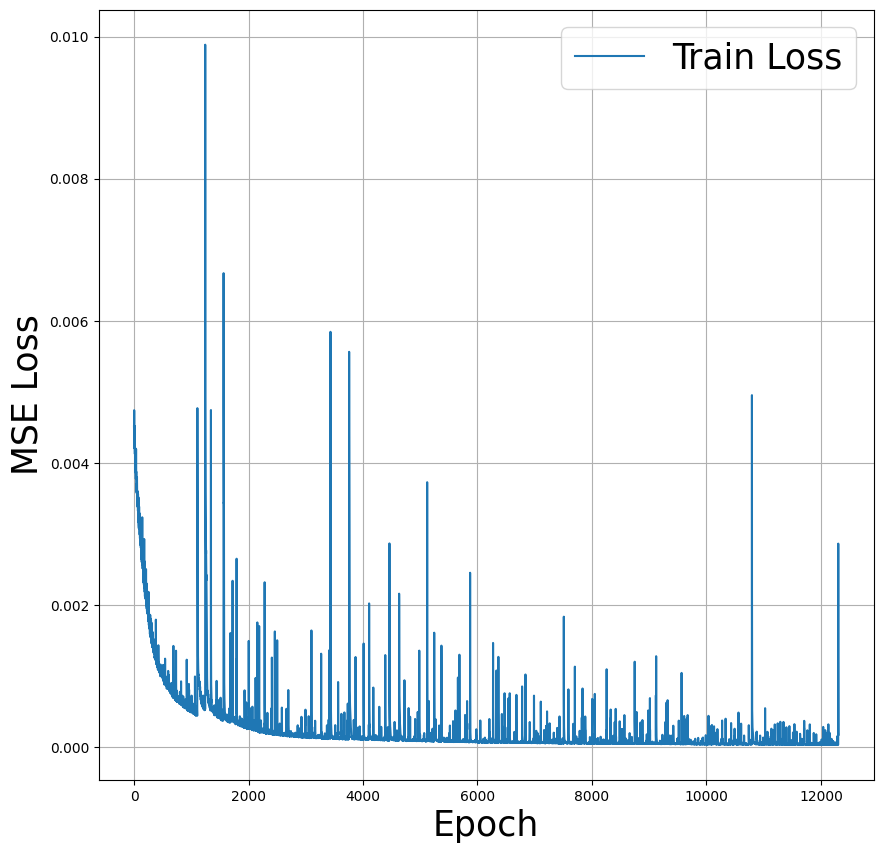

In [46]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.legend(['Train Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.grid()
plt.show()

In [37]:
def change_to_date(date_num): # 更改数字日期到真实日期
    date_num = date_num.cpu().numpy()
    date_list = []
    for date in date_num:
        date_list.append(str(date)[:4]+'-'+str(date)[4:6]+'-'+str(date)[6:8])
    return date_list

F:\ENV_py\PYTORCH\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


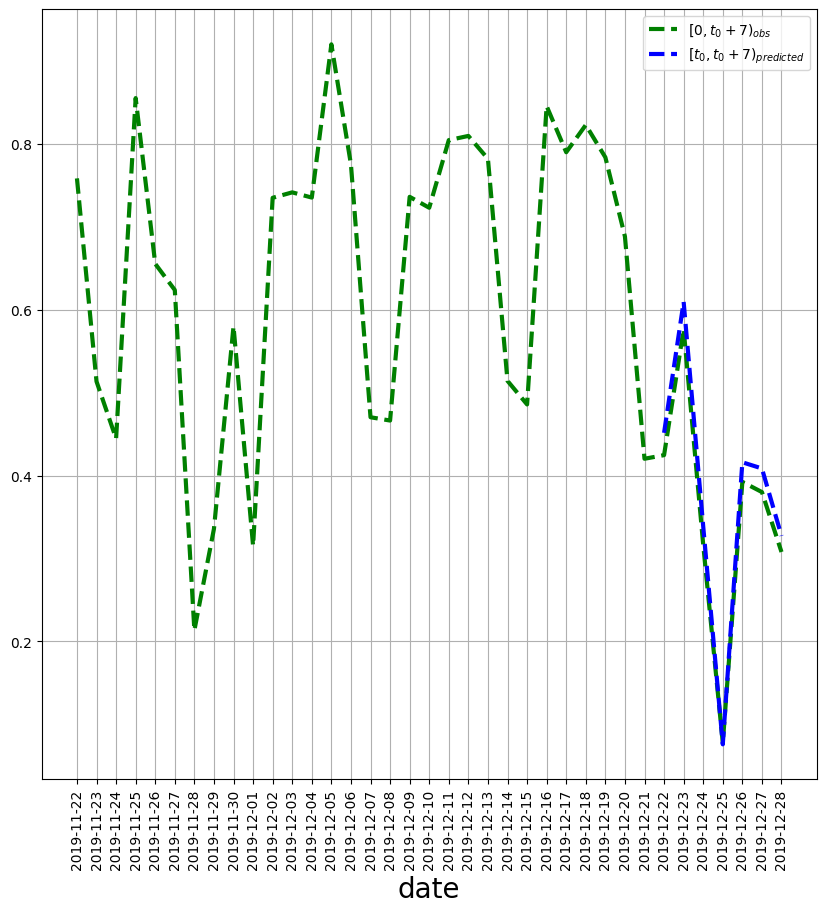

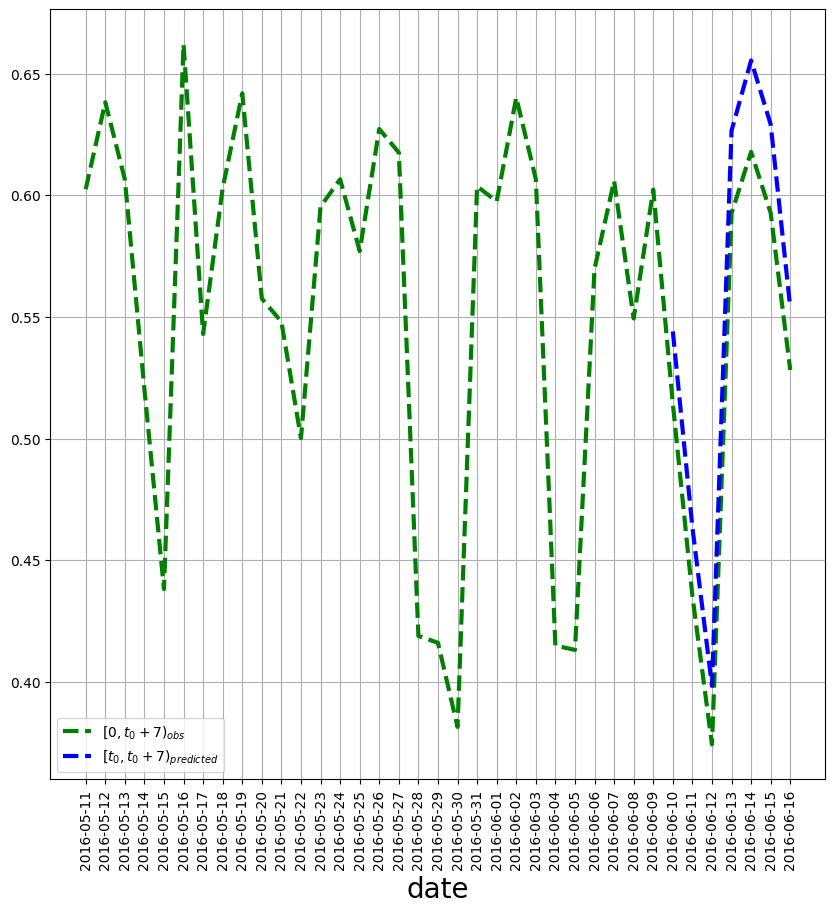

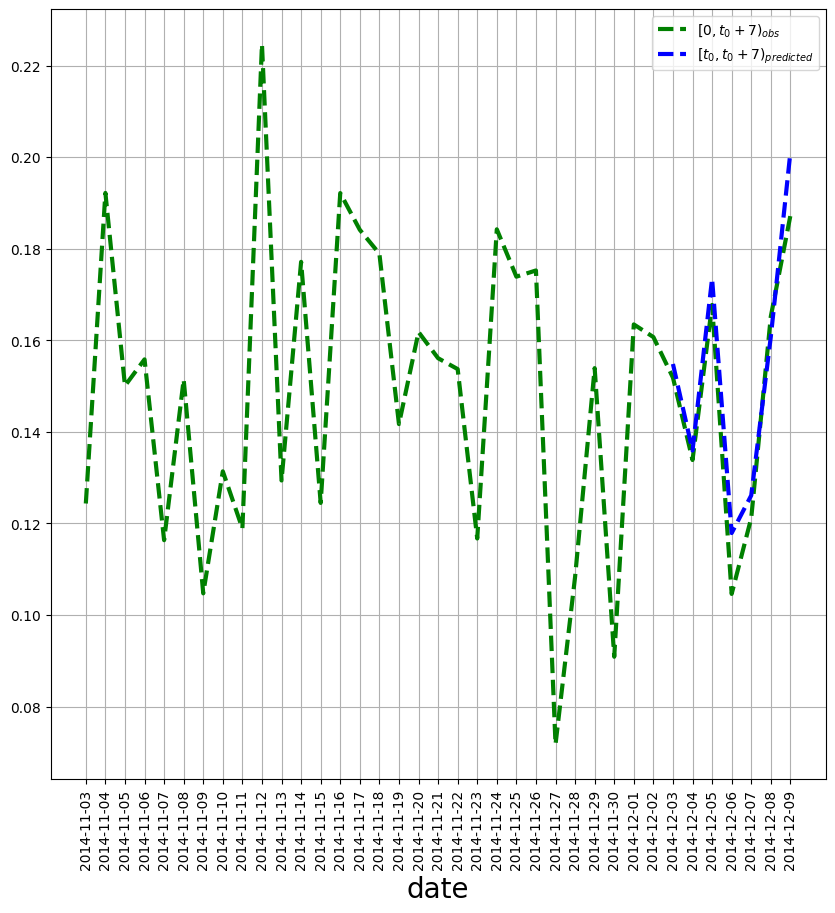

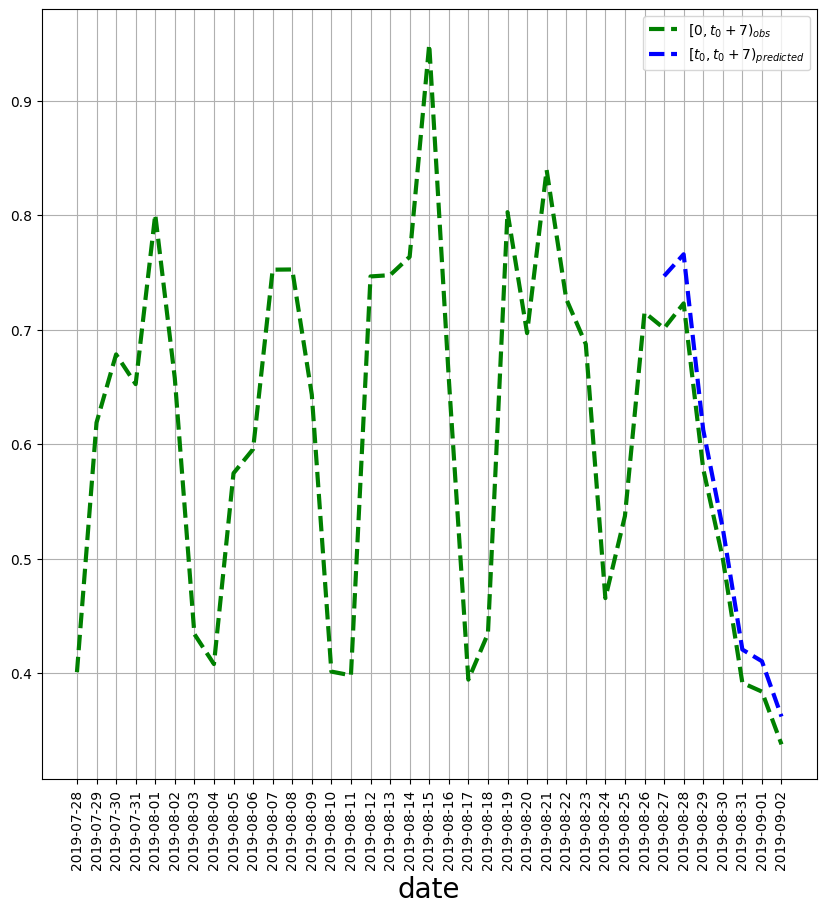

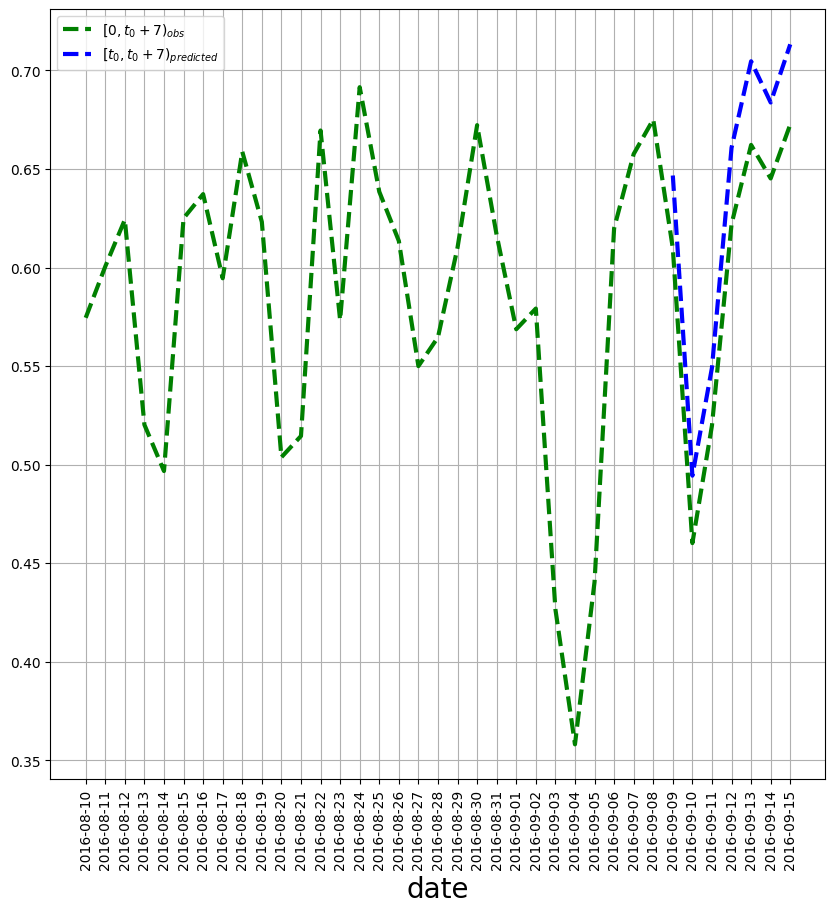

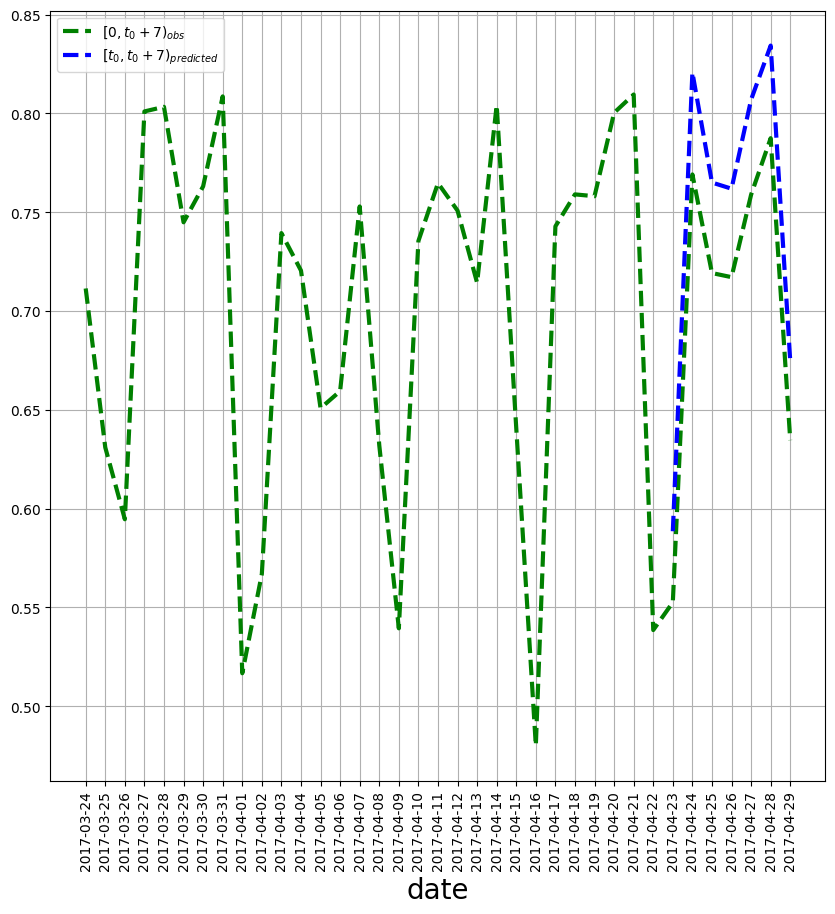

In [39]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,[x,y, times] in enumerate(train_dl):
        output = test_model(x.cuda().float(),y.cuda().float())
        # x[batch, seq_len]
        # y[batch, seq_len]
        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            date_list =change_to_date(times[0])
            plt.xticks(x[0], date_list)
            plt.xticks(rotation=90)
            plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
            plt.plot(x[0,train_length:].cpu().detach().squeeze().numpy(),output[0,(train_length-1):(train_length+forcast_window-1)].cpu().detach().squeeze(-1).numpy(),'b--',linewidth=3) # not missing data
            # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
            plt.xlabel("date",fontsize=20)
            plt.legend(["$[0,t_0+{7})_{obs}$","$[t_0,t_0+{7})_{predicted}$"])
            plt.grid()
            plt.show()

In [26]:
def generate_square_subsequent_mask(train_length, forcast_window):
        mask = torch.zeros(train_length + forcast_window, train_length + forcast_window)
        for i in range(0, train_length):
            mask[i, train_length:] = 1
        for i in range(train_length, train_length + forcast_window):
            mask[i, i + 1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))  # .masked_fill(mask == 1, float(0.0))
        return mask

In [27]:
def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1) # (sequence len,Batch size,embedding_size)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings

        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            print(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].shape)
            print(len(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)))
            #[?, ?, seq_len, seq_len]
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)

        return attn_layer_i

In [28]:
idx_example = 0

In [29]:
attn_layers = get_attn(model,test_data[idx_example][0].unsqueeze(0),test_data[idx_example][1].unsqueeze(0),test_data[idx_example][2])

torch.Size([1, 37, 37])
2
torch.Size([1, 37, 37])
2
torch.Size([1, 37, 37])
2
torch.Size([1, 37, 37])
2


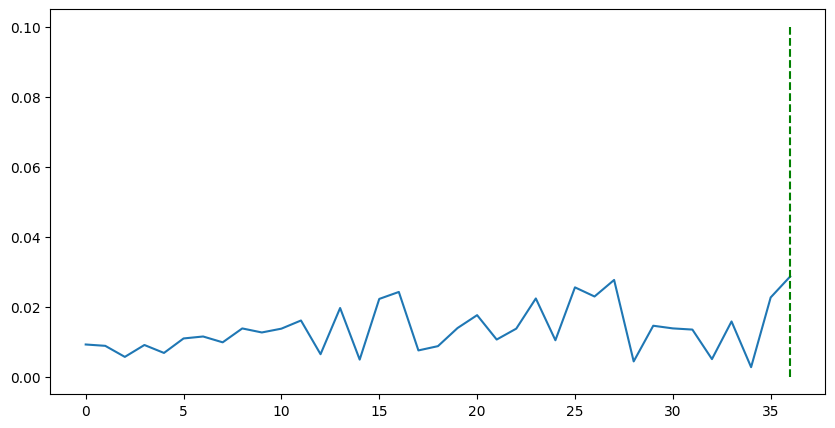

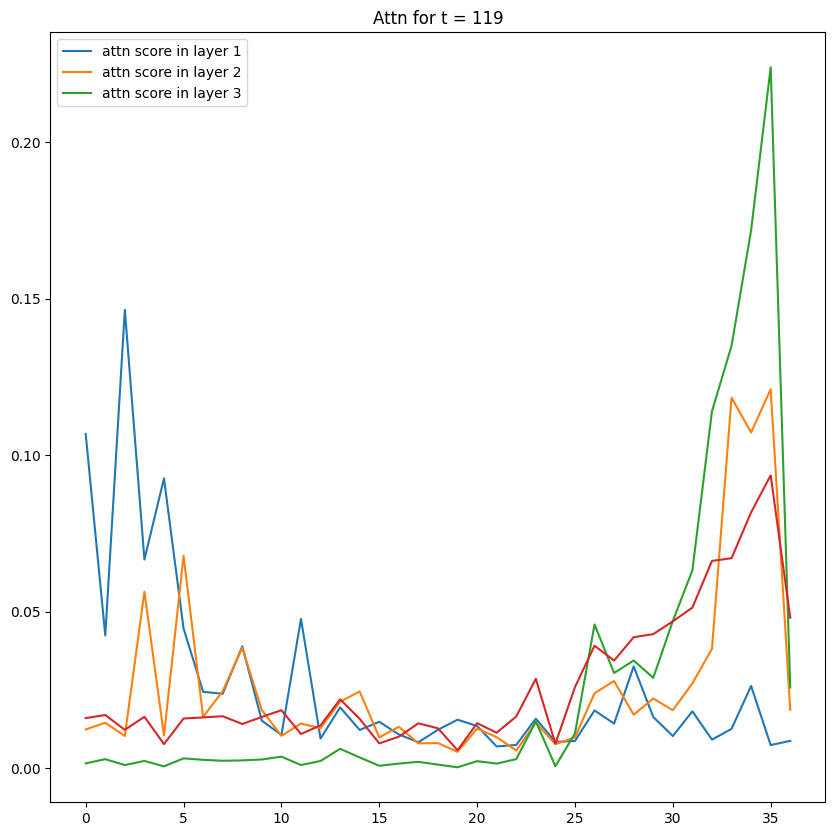

In [30]:
plt.figure(figsize=(10,5))
plt.plot(test_data[idx_example][0].numpy(),train_data[10][1].numpy())
plt.plot([train_length+forcast_window-1,train_length+forcast_window-1],[0,0.1],'g--') # not missing data
# plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # missing data
plt.figure(figsize=(10,10))
plt.plot(attn_layers[0][train_length+forcast_window-1]) # not missing data
plt.plot(attn_layers[1][train_length+forcast_window-1]) # not missing data
plt.plot(attn_layers[2][train_length+forcast_window-1])
plt.plot(attn_layers[3][train_length+forcast_window-1]) # not missing data

#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[0][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[1][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[2][119-10]) # missing data



plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3"])
plt.title("Attn for t = 119") # not missing data

plt.show()